In [1]:
import numpy as numpy
import os, shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
from keras.applications import VGG19, MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model

In [2]:
# if not os.path.isdir("val_images"):
#     os.mkdir("val_images")

In [3]:
# classes = ['COVID-19', 'NORMAL', 'Viral Pneumonia']

In [4]:
# for c in classes:
#     if not os.path.isdir("val_images/" + c):
#         os.mkdir("val_images/" + c)

In [5]:
# split = 0.9
# for dirc in os.listdir("images"):
#     p = "images/" + dirc
#     imgs = os.listdir(p)
#     split_size = int(len(imgs)*split)
#     files_to_move =  imgs[split_size:]
#     print(files_to_move)
#     print()
#     for f in files_to_move:
#         src = os.path.join(p,f)
#         dest = os.path.join("val_images/",dirc)
#         shutil.move(src,dest)

### Image Augmentation

In [6]:
train_datagen = image.ImageDataGenerator(rotation_range=0.25,
                                         width_shift_range=0.25,
                                         height_shift_range=0.25,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         preprocessing_function=preprocess_input)

In [7]:
val_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [8]:
train_generator = train_datagen.flow_from_directory("./images",
                                                     target_size=(224,224),
                                                     class_mode="categorical",
                                                     shuffle=True,
                                                     batch_size=64
                                                     )

Found 2613 images belonging to 3 classes.


In [9]:
train_generator.class_indices

{'COVID-19': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

In [10]:
d, l = next(train_generator)

In [11]:
d.shape, l.shape

((64, 224, 224, 3), (64, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[0. 0. 1.]


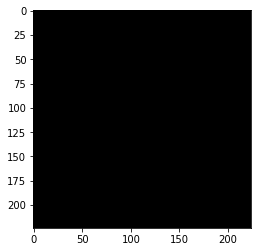

In [12]:
plt.imshow(d[0].astype('int32'))
print(l[0])

In [13]:
val_generator = val_datagen.flow_from_directory("./val_images",
                                                 target_size=(224, 224),
                                                 class_mode="categorical",
                                                 batch_size = 64
                                                 )

Found 292 images belonging to 3 classes.


### Model Building

In [56]:
v2 = MobileNetV2(include_top = False, weights = "imagenet", input_shape=(224,224,3))

In [57]:
headModel = v2.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(32, activation='relu')(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [58]:
model = Model(inputs = v2.input, outputs = headModel)

In [59]:
for l in v2.layers:
    l.trainable = False

model.compile(optimizer="Adam", loss = "categorical_crossentropy", metrics=["accuracy"])

model.summary()

N[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 14, 14, 384)  1536        block_7_expand[0][0]             
__________________________________________________________________________________________________
block_7_expand_relu (ReLU)      (None, 14, 14, 384)  0           block_7_expand_BN[0][0]          
__________________________________________________________________________________________________
block_7_depthwise (DepthwiseCon (None, 14, 14, 384)  3456        block_7_expand_relu[0][0]        
__________________________________________________________________________________________________
block_7_depthwise_BN (BatchNorm (None, 14, 14, 384)  1536        block_7_depthwise[0][0]          
__________________________________________________________________________________________________
block_7_depthwise_relu (ReLU)   (None, 14, 14, 384)  0           block_7_depthwise_BN[0][0] 

In [65]:
hist = model.fit(train_generator, 
                           steps_per_epoch=2613//64,
                           validation_data=val_generator, 
                           validation_steps=292//64, 
                           epochs=30)

Epoch 1/30
40/40 [==============================] - 158s 4s/step - loss: 0.3484 - accuracy: 0.8603 - val_loss: 0.2702 - val_accuracy: 0.9141
Epoch 2/30
40/40 [==============================] - 318s 8s/step - loss: 0.3891 - accuracy: 0.8541 - val_loss: 0.2472 - val_accuracy: 0.9062
Epoch 3/30
40/40 [==============================] - 343s 9s/step - loss: 0.4289 - accuracy: 0.8387 - val_loss: 0.2130 - val_accuracy: 0.9336
Epoch 4/30
40/40 [==============================] - 269s 7s/step - loss: 0.3876 - accuracy: 0.8501 - val_loss: 0.2245 - val_accuracy: 0.9375
Epoch 5/30
40/40 [==============================] - 291s 7s/step - loss: 0.3838 - accuracy: 0.8545 - val_loss: 0.2603 - val_accuracy: 0.9180
Epoch 6/30
40/40 [==============================] - 275s 7s/step - loss: 0.3872 - accuracy: 0.8525 - val_loss: 0.2200 - val_accuracy: 0.9336
Epoch 7/30
40/40 [==============================] - 254s 6s/step - loss: 0.3693 - accuracy: 0.8603 - val_loss: 0.2003 - val_accuracy: 0.9453
Epoch 8/30
40

KeyboardInterrupt: 

In [69]:
model.evaluate(val_generator)

5/5 [==============================] - 10s 2s/step - loss: 0.2083 - accuracy: 0.9349


[0.20828132331371307, 0.9349315166473389]

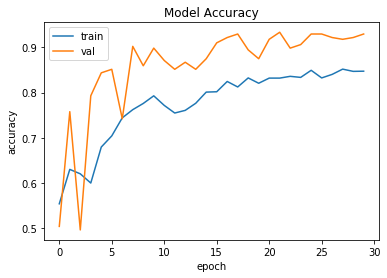

In [70]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

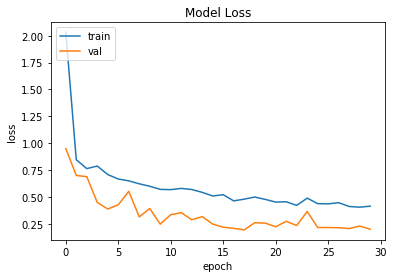

In [71]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [72]:
model.save("Xray_v2.1.h5")